<a href="https://colab.research.google.com/github/blakelobato/Predicting-Asteroid-Diameter/blob/master/Main_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Blake Peter Lobato

*Unit 2, Sprint 4, Build Week*

#*Predicting Asteroid Diameters Regression Analysis*

---



#INTRODUCTION

**Purpose for Project:** 

The inspiration for this project came from a kaggle competition on prediciting asteroid diameter size. The link is here: https://www.kaggle.com/basu369victor/prediction-of-asteroid-diameter.

I have always had a fascination with space and astronomy. I feel there is a budding and unexplored world, in which, machine learning can vastly improve mankind's knowledge of the solar system. 


There has been some extensive research into predicting asteroid diameters due to the potential damage they bring if these objects are to impact Earth. Yet, due to the lack of sufficient data, inability to get near these asteroids, and no clear cut formula for predicting their size; the field of asteroid size prediction is rudimentary at best. 


The information and inspiration was provided by Victor Basu of the CSE Jalpaiguri Government Engineering College West Bengal, India. He created the kaggle post and directed me to the NASA/JPL Solar System Dynamics website. 

Mr. Basu states, "Your job is to surpass my work and make a better model with higher accuracy and the least error possible than mine.", and thus there was my motivation. 


The NASA/JPL SSD query helped me generate my dataset for this project (link: https://ssd.jpl.nasa.gov/sbdb_query.cgi#x). 


My hope is to emmulate Mr. Basu's research, improve his models/accuracy, and write my own research paper on the findings that will be converted into a blog post on other platforms. On top of that, I hope to deploy an application that will take values to predict the diameter of an asteroid with accuracy. 

## DATA CLEANING **NIGHTMARE**

- Started with 840,644 rows by 76 columns (merged object fields with orbital and model parameter fields)

- Could not store a dataset this size in github (>25MB) had to use so I had to use this website to get around that: https://git-lfs.github.com/. Git lfs allows large files to be uploaded locally and returns pointers to the values, that way we can work with the data and use the links in github! (S/O Tim for helping on that for a good hour and half)

- *LIFE LESSON* ~ When using a trial application make sure and do what you need to do before it either expires or exceeds your free limit!!!

  - Exceed my limited bandwidth limit... Got my files deleted from git lfs before I was able to condense the data set

- Next Steps... **Eliminate missing values, outliers, irrelevant data, high cardinality categorical columns, and feature engineering:**

  - Had to manually upload my 84 MB data set
  - Ran a pandas profiling report over night (took 18 hours in total!)
    - Gave valuable insight on DateTime columns, the target 'diameter' column not being in float format, repeated/highly correlated columns, and missing columns.
  - Had to remove missing values (several columns were missing over 90% of their values)
  - Removed outliers of the target column 'diameter' in order to have a more evenly distributed curve without ruining the integrity of the data
  -  Removed all the data specific to comets and not asteroids (there is a difference)
  - Removed all high cardinality categorical columns 
  - Finally used datetime columns to create four new features on the first and last year/month the asteroid was observed



## Clean Data Analysis 


The columns that were used in final version for the predicative model were as follows:


*   **diameter: This is the target variable for this project. It is in km for the unit.**
*   orbit_id: Orbital solution ID
*   e: Eccentricity of the orbit
*   a: Semi-Major Axis in units (AU)
*   i: Inclination; angle with respect to x-y ecliptic plane (deg) 
*   om: Longitude of the ascending Node (deg)
*   w: Argument of Perihelion (deg)
*   ma: Mean anomly (deg)
*   n: Mean Motion (deg/d) 
*   tp: Time of perihelion passage 
*   moid: Earth minimum orbit intersection distance (au)
*   moid_jup: Jupiter minimum orbit intersection distance (au) 
*   class: Orbit Classification
*   producer: Name of Person (or Institution) Who Computed the Orbit 
*   data_arc: Number of days spanned by the data-arc (days)
*   n_obs_used: Number of observations used in the orbit fit (all types)
*   rms: Normalized Root Mean Square of orbit fit (arcsec)
*   albedo: Geometric albedo
*   first_year_obs: The year of the first observation
*   first_month_obs: The month of the first observation
*   last_year_obs: The year of the last observation
*   last_month_obs: The month of the last observation


In [0]:
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install plotly==4.*
!pip install eli5
!pip install pdpbox
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip;

# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Future Warning Avoidance with XGBoost
# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

     |████████████████████████████████| 102kB 2.2MB/s 
     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 614kB 49.7MB/s 
     |████████████████████████████████| 235kB 62.5MB/s 
     |████████████████████████████████| 307kB 53.6MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 215kB 52.2MB/s 
     |████████████████████████████████| 737kB 51.3MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.4.0-py2.py3-none-any.whl size=195587 sha256=5da952628d2525e922283c8d24fb3fc099f34b1abda0ca2d450796cf6bec773c
  Stored in directory: /root/.cache/pip/wheels/b2/4b/40/ff4633a59f4e7fbdfec19b8e10e353b54b5eef125c31afe51a
  Created wheel for confuse: filename=confuse-1.0.0-cp36-none-any.whl size=17486 sha256=95d56d11ed7a74658f833fa1a569838d48ba4d7cb0a59fce11e8535db65ef7fc
  Stored in directory: /root/.cache/pip/wheels/b0/b2/96/2074eee7dbf

# Define ML problems
- Choose a target to predict, and check its distribution
  - Target for this project was the diameter in km of the asteroid
  - Removed outliers via IQR method (took less than 7% of the data frame off by outlier removal)
  - Right skewed even after outlier removal (not as bad as before)

- Choose an appropriate evaluation metric
  - Evaluation metrics used were R^2 values, mean absolute error values, and mean squared error values. 


- Avoid leakage of information from test to train or from target to features
  - Removed columns that could potentially leak information of the diameter to the training model in the data cleaning stage. 

In [0]:
#load in the data from local file

df = pd.read_csv('/content/Pred_Ast_Diam_2.csv')
print(df.shape)
df.head()

#Size of dataframe is 126,497 x 23 (not encoded)

(126497, 23)


orbit_id         e         a  ...  first_month_obs  last_obs_year  last_obs_month
0   JPL 35  0.242027  2.201791  ...               10           2019              10
1   JPL 25  0.256856  2.338209  ...                4           2019               8
2   JPL 28  0.160543  2.228812  ...                9           2019               5
3   JPL 35  0.167945  2.241299  ...               10           2019              11
4   JPL 34  0.253295  2.467536  ...                2           2019               5

[5 rows x 23 columns]

In [0]:
import pandas_profiling
df.profile_report()


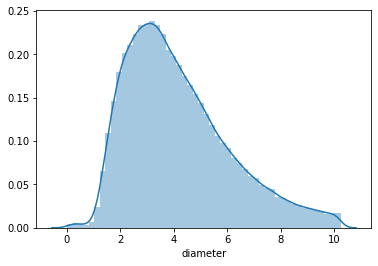

In [0]:
#Look at the distribution of the target variable
sns.distplot(df.diameter)

### Was a much uglier distribution before data cleaning and outlier handling. 

* Photo of the distribution pre-cleaning can be found on link below *
(https://drive.google.com/open?id=1xYGLUj3Rrb3COpND3ZjiKXcpFvCIAzw3)

- It was crucial to change it to a float format because it would throw errors when trying to make visualizations on 'diameter'. 


In [0]:
#Ensuring all the missing values have been taken care of previously 
df.isna().sum()

orbit_id           0
e                  0
a                  0
i                  0
om                 0
w                  0
ma                 0
n                  0
tp                 0
moid               0
moid_jup           0
class              0
producer           0
data_arc           0
n_obs_used         0
rms                0
diameter           0
albedo             0
diameter_sigma     0
first_year_obs     0
first_month_obs    0
last_obs_year      0
last_obs_month     0
dtype: int64

In [0]:
# Get an idea of the different means, distributions, and values associated with the features
df.describe()

e              a  ...  last_obs_year  last_obs_month
count  126497.000000  126497.000000  ...  126497.000000   126497.000000
mean        0.146644       2.756965  ...    2018.317351        6.839364
std         0.076841       0.453027  ...       2.010448        3.590190
min         0.000488       0.626226  ...    2000.000000        1.000000
25%         0.091182       2.510297  ...    2019.000000        4.000000
50%         0.140047       2.729370  ...    2019.000000        6.000000
75%         0.192297       3.074005  ...    2019.000000       11.000000
max         0.968381      69.576833  ...    2019.000000       12.000000

[8 rows x 20 columns]

In [0]:
# look at possibly doing a time split for this data
df.first_year_obs.describe()

count    126497.000000
mean       1995.518985
std          11.947776
min        1892.000000
25%        1993.000000
50%        1998.000000
75%        2001.000000
max        2014.000000
Name: first_year_obs, dtype: float64

In [0]:
#Start with splitting the data into a train, validation, and test case using an 80/20 split.

from sklearn.model_selection import train_test_split
# Split into Train and Test sets
train, test = train_test_split(df, train_size=.80, test_size=0.20, random_state=42)

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)

train.shape, val.shape, test.shape

### What would be the system for time dependent on first observed

#train = df[df.Date.dt.year <= 2016]
#val = df[df.Date.dt.year == 2017]
#test = df[df.Date.dt.year >= 2018]

((80957, 23), (20240, 23), (25300, 23))

In [0]:
#Get an idea of what the train dataframe now looks like (random selection of rows from the original dataframe)
train.head()

orbit_id         e  ...  last_obs_year  last_obs_month
47132    JPL 16  0.120403  ...           2019               5
3303     JPL 30  0.054356  ...           2019              11
20238    JPL 20  0.127246  ...           2019              11
118643    JPL 5  0.328479  ...           2010               2
9231     JPL 32  0.208735  ...           2019              11

[5 rows x 23 columns]

In [0]:
#columns are the features we are using 
train.columns

Index(['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid',
       'moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms',
       'diameter', 'albedo', 'diameter_sigma', 'first_year_obs',
       'first_month_obs', 'last_obs_year', 'last_obs_month'],
      dtype='object')

In [0]:
# Reminder to myself which columns are categorical and numeric
features = ['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
numeric_cols = ['e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
#categorical_cols = ['orbit_id, 'class', 'producer']
target = 'diameter'

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## Analysis 

- First attempted linear regressions and multiple feature regressions
  - This was not very useful due to the complexity of the dataset so I transitioned into focusing on Decision Trees, Random Forests, and XGBoosting.

## Baseline Model for Dataset

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Arrange y target vectors
target = 'diameter'
y_train = train[target]
y_val = val[target]
y_test = test[target]

# Get mean baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

# Train Error
y_pred = [guess] * len(y_train)
mae_t = mean_absolute_error(y_train, y_pred)
mse_t = mean_squared_error(y_train, y_pred)
r2_t = r2_score(y_train, y_pred)
print(f'Training MAE Error: {mae_t:.2f} km standarized')
print(f'Training MSE Error: {mse_t:.2f} km standarized')
print(f'Training R^2 Error: {r2_t:.2f}%')


# Validation Error
y_pred = [guess] * len(y_val)
mae_v = mean_absolute_error(y_val, y_pred)
mse_v = mean_squared_error(y_val, y_pred)
r2_val = r2_score(y_val, y_pred)
print(f'Validation MAE Error: {mae_v:.2f} km standarized ')
print(f'Validation MSE Error: {mse_v:.2f} km standarized')
print(f'Validation R^2 Error: {r2_val:.2f}%')




Mean Baseline (using 0 features)
Train MAE Error: 1.54 km standarized
Train MSE Error: 3.74 km standarized
Train R^2 Error: 0.00%
Validation MAE Error: 1.55 km standarized 
Validation MSE Error: 3.73 km standarized
Validation R^2 Error: -0.00%


## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

#1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
model = LinearRegression()

# 3. Arrange X features matrices (already did y target vectors)
featurelr = ['n_obs_used']
X_train = train[featurelr]
X_val = val[featurelr]
X_test = test[featurelr]
print(f'Linear Regression, dependent on {featurelr}:')

# 4. Fit the model
model.fit(X_train, y_train)
y_pred_t = model.predict(X_train)
mae_t = mean_absolute_error(y_train, y_pred_t)
mse_t = mean_squared_error(y_train, y_pred_t)
r2_t = r2_score(y_train, y_pred_t)
print(f'Training MAE Error: {mae_t:.2f} km standarized')
print(f'Training MSE Error: {mse_t:.2f} km standarized')
print(f'Training R^2 Error: {r2_t:.4f}')

# 5. Apply the model to new data
y_pred_v = model.predict(X_val)
mae_v = mean_absolute_error(y_val, y_pred_v)
mse_v = mean_squared_error(y_val, y_pred_v)
r2_val = r2_score(y_val, y_pred_v)
print(f'Validation MAE Error: {mae_v:.2f} km standarized ')
print(f'Validation MSE Error: {mse_v:.2f} km standarized')
print(f'Validation R^2 Error: {r2_val:.4f}')



Linear Regression, dependent on ['n_obs_used']:
Training MAE Error: 1.45 km standarized
Training MSE Error: 3.26 km standarized
Training R^2 Error: 0.1281
Validation MAE Error: 1.45 km standarized 
Validation MSE Error: 3.22 km standarized
Validation R^2 Error: 0.1363


- *NOTE: This is better than the baseline guess of 1.54 km standardized*

# Decision Tree and Decision Tree Visualization

In [0]:
#import all the possible things needed for making my pipeline

import category_encoders as ce
#from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
#from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

features = ['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
target = 'diameter'

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)

# Create a pipeline, one hot encode the low cardinality values, ordinal encode the higher cardinalaity, scale everythgin, run deceison tree regression
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    DecisionTreeRegressor(criterion='mse', max_depth=15, min_samples_leaf=15, min_samples_split=4, random_state=42)
)

# fit the pipeline on training data
pipeline.fit(X_train,y_train)


y_pred_train = pipeline.predict(X_train)
y_pred_val = pipeline.predict(X_val)


print('- Training R^2 value', pipeline.score(X_train, y_train))
print('- Validation R^2 value', pipeline.score(X_val, y_val))
print(f'- Training MAE: {mean_absolute_error(y_train,y_pred_train)} km (standarized)')
print(f'- Validation MAE: {mean_absolute_error(y_val,y_pred_val)} km (standarized)')
print(f'- Training MSE: {mean_squared_error(y_train,y_pred_train)} km (standarized)')
print(f'- Validation MSE: {mean_squared_error(y_val,y_pred_val)} km (standarized)')



- Training R^2 value 0.917263649870226
- Validation R^2 value 0.8549974309456507
- Training MAE: 0.39861162871440853 km (standarized)
- Validation MAE: 0.5261486856804322 km (standarized)
- Training MSE: 0.30953821547887295 km (standarized)
- Validation MSE: 0.5412143008851001 km (standarized)


# Hyper Parameter Optimization for Decision Tree Regressor

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

features = ['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
target = 'diameter'
X_train = train[features]
X_train = train.drop(columns=target)
y_train = train[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    DecisionTreeRegressor(random_state=42)
)

#different parameter distributions to test for the best possible combination
param_distributions = {
   'decisiontreeregressor__min_samples_leaf': [1, 3, 5, 7, 9, 10, 15], 
    'decisiontreeregressor__max_depth': [5, 7, 9, 10, 13, 15, 17, 20, 21,  25, 30], 
    'decisiontreeregressor__min_samples_split': [2, 3, 4, 5, 7],
}




# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  3

In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'decisiontreeregressor__min_samples_split': 4, 'decisiontreeregressor__min_samples_leaf': 15, 'decisiontreeregressor__max_depth': 15}
Cross-validation MAE 0.5311198765325745


## Decision Tree Results

-- r^2 on y, min sample leaf on x (looking to max X_val r^2, larger smaples min leaf the more simple the model which is what we want)




criterion='mse', max_depth=15, min_samples_leaf=10, min_samples_split=2,

- Training R^2 value 0.9292348937178739
- Validation R^2 value 0.849876385354756
- Training MAE: 0.3695880775623763 km (standarized)
- Validation MAE: 0.5337221385327309 km (standarized)
- Training MSE: 0.26475067708914296 km (standarized)
- Validation MSE: 0.5603283285009698 km (standarized)

==============================================================================

criterion='mse', max_depth=20, min_samples_leaf=10, min_samples_split=2,

- Training R^2 value 0.9346948339613518
- Validation R^2 value 0.8488548244848121
- Training MAE: 0.34951813131681714 km (standarized)
- Validation MAE: 0.5363070275864531 km (standarized)
- Training MSE: 0.24432361985327875 km (standarized)
- Validation MSE: 0.5641412495798438 km (standarized)

==============================================================================

criterion='mse', max_depth=25, min_samples_leaf=10, min_samples_split=2,

- Training R^2 value 0.9347864509303685
- Validation R^2 value 0.8488116581393707
- Training MAE: 0.34899645361069465 km (standarized)
- Validation MAE: 0.5364081452202768 km (standarized)
- Training MSE: 0.24398085693163035 km (standarized)
- Validation MSE: 0.5643023656457329 km (standarized)

==============================================================================

criterion='mse', max_depth=25, min_samples_leaf=7, min_samples_split=2,

- Training R^2 value 0.9494021803387641
- Validation R^2 value 0.8404111515720607
- Training MAE: 0.3045925377034534 km (standarized)
- Validation MAE: 0.5530342858487856 km (standarized)
- Training MSE: 0.18929960991141925 km (standarized)
- Validation MSE: 0.5956568052157194 km (standarized)


==============================================================================


criterion='mse', max_depth=25, min_samples_leaf=5, min_samples_split=2,

- Training R^2 value 0.963186949798227
- Validation R^2 value 0.8318904353109088
- Training MAE: 0.2548710083266907 km (standarized)
- Validation MAE: 0.5701545487305295 km (standarized)
- Training MSE: 0.1377272002924657 km (standarized)
- Validation MSE: 0.6274599210114894 km (standarized)


==============================================================================

criterion='mse', max_depth=25, min_samples_leaf=3, min_samples_split=2,

- Training R^2 value 0.982247945460246
- Validation R^2 value 0.8157187435652395
- Training MAE: 0.16796476456093865 km (standarized)
- Validation MAE: 0.5940769656839733 km (standarized)
- Training MSE: 0.06641505547078327 km (standarized)
- Validation MSE: 0.6878198918681518 km (standarized)

==============================================================================

criterion='mse', max_depth=20, min_samples_leaf=1, min_samples_split=5,

- Training R^2 value 0.9905104596415893
- Validation R^2 value 0.8013948318281574
- Training MAE: 0.1192397059759955 km (standarized)
- Validation MAE: 0.6108364448843869 km (standarized)
- Training MSE: 0.03550283984789992 km (standarized)
- Validation MSE: 0.7412831230873116 km (standarized)

==============================================================================

criterion='mse', max_depth=21, min_samples_leaf=1, min_samples_split=4,

- Training R^2 value 0.9944123957461862
- Validation R^2 value 0.7978189891401823
- Training MAE: 0.08397262460136339 km (standarized)
- Validation MAE: 0.6177860431715212 km (standarized)
- Training MSE: 0.02090468151924503 km (standarized)
- Validation MSE: 0.7546297638611181 km (standarized)

==============================================================================

criterion='mse', max_depth=21, min_samples_leaf=4, min_samples_split=4,

- Training R^2 value 0.9717910012264598
- Validation R^2 value 0.8233470425572914
- Training MAE: 0.2206328755859343 km (standarized)
- Validation MAE: 0.5840835276489734 km (standarized)
- Training MSE: 0.1055372049541875 km (standarized)
- Validation MSE: 0.6593476755974291 km (standarized)

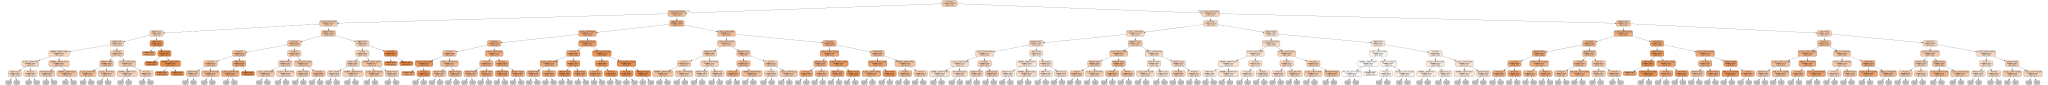

In [0]:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

ord_encoder = ce.OrdinalEncoder(cols = ['orbit_id'])
X_train_ordencoded = ord_encoder.fit_transform(X_train)
X_val_ordencoded = ord_encoder.transform(X_val)

oh_encoder = ce.OneHotEncoder(use_cat_names=True, cols=['class','producer'])
X_train_encoded = oh_encoder.fit_transform(X_train_ordencoded)
X_val_encoded = oh_encoder.transform(X_val_ordencoded)

dt = pipeline.named_steps['decisiontreeregressor']

dt.fit(X_train_encoded,y_train)

encoded_columns = X_train_encoded.columns

dot_data = export_graphviz(dt, 
                           out_file=None, 
                           max_depth=7, 
                           feature_names=encoded_columns,
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

# Random Forest

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

features = ['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
target = 'diameter'

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    RandomForestRegressor(n_estimators=450, max_depth=None, max_features=.77, min_samples_leaf=3, min_samples_split=3,  n_jobs=-1, random_state=42)
)

pipeline.fit(X_train,y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_val = pipeline.predict(X_val)



print('Training R^2 value', pipeline.score(X_train, y_train))
print('Validation R^2 value', pipeline.score(X_val, y_val))
print(f'Training MAE: {mean_absolute_error(y_train,y_pred_train)} km (standarized)')
print(f'Validation MAE: {mean_absolute_error(y_val,y_pred_val)} km (standarized)')
print(f'Training MSE: {mean_squared_error(y_train,y_pred_train)} km (standarized)')
print(f'Validation MSE: {mean_squared_error(y_val,y_pred_val)} km (standarized)')



Training R^2 value 0.9765620838601097
Validation R^2 value 0.9091790806599088
Training MAE: 0.20060518792210347 km (standarized)
Validation MAE: 0.4129943805935859 km (standarized)
Training MSE: 0.08768734329113632 km (standarized)
Validation MSE: 0.33898420343136143 km (standarized)


### Hyper Parameter Optimization for Random Forest Regressor

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import random
from scipy.stats import randint, uniform
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


features = ['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
target = 'diameter'
X_train = train[features]
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val[features]
X_val = val.drop(columns=target)
y_val = val[target]


pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

#parameters we are adjusting to find the optimal numbers
param_distributions = {
   'randomforestregressor__n_estimators': range(100, 500, 50), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1),
    'randomforestregressor__min_samples_split': [2, 3],
    'randomforestregressor__min_samples_leaf': [3, 5, 7, 10],
}




# If you're on Colab, decrease n_iter & cv parameters
searchrf = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

searchrf.fit(X_train, y_train);
print('Best hyperparameters', searchrf.best_params_)
print('Cross-validation MAE', -searchrf.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 77.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 95.3min
[Parallel(n_jobs=-1)]: Done 

Best hyperparameters {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 0.7742957829583296, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 450}
Cross-validation MAE 0.4214062364446114


In [0]:
print('Best hyperparameters', searchrf.best_params_)
print('Cross-validation MAE', -searchrf.best_score_)

NameError: ignored

In [0]:
X_train.shape

(80957, 22)

In [0]:
rf = pipeline.named_steps['randomforestregressor']



In [0]:
#gets number of features after encoding 
len(rf.feature_importances_)

35

In [0]:
# ordinal encoding orbit id for the train and validation sets
ord_encoder = ce.OrdinalEncoder(cols = ['orbit_id'])
X_train_ordencoded = ord_encoder.fit_transform(X_train)
X_val_ordencoded = ord_encoder.transform(X_val)

In [0]:
# one hot encoding for class and producer as they are lower cardinality
oh_encoder = ce.OneHotEncoder(use_cat_names=True, cols=['class','producer'])
X_train_encoded = oh_encoder.fit_transform(X_train_ordencoded)
X_val_encoded = oh_encoder.transform(X_val_ordencoded)

### Top 20 Features based on importance in random forest regressor

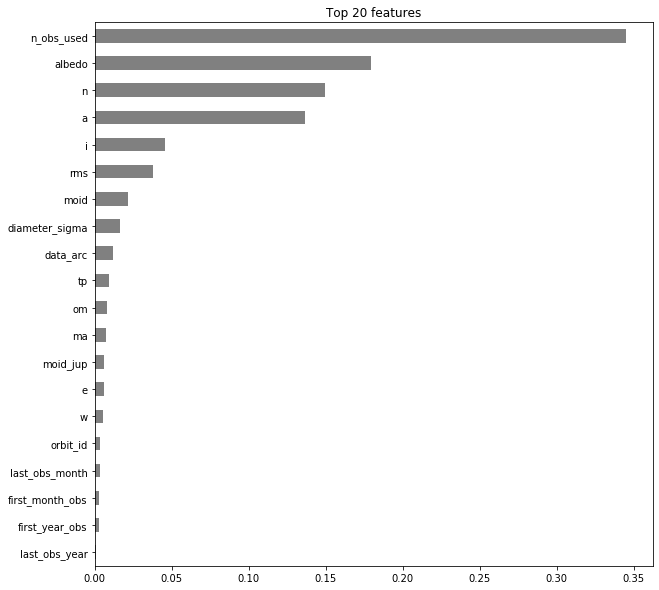

In [0]:
#Ordinal Encoding outside the pipeline
ord_encoder = ce.OrdinalEncoder(cols = ['orbit_id'])
X_train_ordencoded = ord_encoder.fit_transform(X_train)
X_val_ordencoded = ord_encoder.transform(X_val)

#One Hot Encoding outside the pipeline
oh_encoder = ce.OneHotEncoder(use_cat_names=True, cols=['class','producer'])
X_train_encoded = oh_encoder.fit_transform(X_train_ordencoded)
X_val_encoded = oh_encoder.transform(X_val_ordencoded)

#calling the random forest regressor
rf = pipeline.named_steps['randomforestregressor']

#fitting the model
rf.fit(X_train_encoded,y_train)

#creating the importances of each feature
importances = pd.Series(rf.feature_importances_, X_train_encoded.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

#Drop Column Importance


In [0]:
features = ['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
target = 'diameter'
X_train = train[features]
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val[features]
X_val = val.drop(columns=target)
y_val = val[target]

In [0]:
print(X_train.shape)
X_train.head(3)

(80957, 22)


orbit_id         e  ...  last_obs_year  last_obs_month
47132   JPL 16  0.120403  ...           2019               5
3303    JPL 30  0.054356  ...           2019              11
20238   JPL 20  0.127246  ...           2019              11

[3 rows x 22 columns]

##Drop Column for Decision Tree

In [0]:
column = 'n_obs_used'

features = ['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
target = 'diameter'

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)

#Fit the data without the columnn 
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    DecisionTreeRegressor(criterion='mse', max_depth=15, min_samples_leaf=10, random_state=42)
)

pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    DecisionTreeRegressor(criterion='mse', max_depth=15, min_samples_leaf=10, random_state=42)
)

pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')


Validation Accuracy without n_obs_used: 0.6827702332326219
Validation Accuracy with n_obs_used: 0.849876385354756
Drop-Column Importance for n_obs_used: 0.1671061521221341


- NOTE: dropping 'n_obs_used' lowers the R^2 value by 16.71% which is considerable in the decesion tree regressor.

In [0]:
X_train.head(1)

orbit_id         e  ...  last_obs_year  last_obs_month
47132   JPL 16  0.120403  ...           2019               5

[1 rows x 22 columns]

In [0]:
features_dc = ['e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
target = 'diameter'

# Arrange data into X features matrix and y target vector 
X_train_dc = train[features_dc]
y_train_dc = train[target]
X_val_dc = val[features_dc]
y_val_dc = val[target]
X_test_dc = test[features_dc]
X_train_dc = train.drop(columns=['orbit_id', 'class','producer', 'diameter'])
X_val_dc = val.drop(columns=['orbit_id','class','producer', 'diameter'])

In [0]:
X_train_dc.head(1)

e         a  ...  last_obs_year  last_obs_month
47132  0.120403  3.134257  ...           2019               5

[1 rows x 19 columns]

In [0]:
# Fit with all the columns
column = 'n_obs_used'

pipeline = make_pipeline(
    #ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    #ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    DecisionTreeRegressor(criterion='mse', max_depth=15, min_samples_leaf=10, random_state=42)
)

pipeline.fit(X_train_dc, y_train_dc)
score_with = pipeline.score(X_val_dc, y_val_dc)
print(f'Validation Accuracy with {column}: {score_with}')

for column in X_train_dc.columns:

  # Fit without column
  pipeline = make_pipeline(
    #ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    #ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    DecisionTreeRegressor(criterion='mse', max_depth=15, min_samples_leaf=10, random_state=42)
)
  pipeline.fit(X_train_dc.drop(columns=column), y_train_dc)
  score_without = pipeline.score(X_val_dc.drop(columns=column), y_val_dc)

  # Compare the error with & without column
  print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy with n_obs_used: 0.8502330152039941
Drop-Column Importance for e: -0.000564019586159481
Drop-Column Importance for a: 1.5391886964644108e-05
Drop-Column Importance for i: 0.026974066760481197
Drop-Column Importance for om: -0.0003253791471519163
Drop-Column Importance for w: -0.0017930077333765393
Drop-Column Importance for ma: -0.0008722164112298092
Drop-Column Importance for n: -2.2214529545316886e-05
Drop-Column Importance for tp: 0.0015574168990812876
Drop-Column Importance for moid: -0.0003328686438502926
Drop-Column Importance for moid_jup: -0.0010986899700499153
Drop-Column Importance for data_arc: -0.0018245717366596192
Drop-Column Importance for n_obs_used: 0.16256166629701596
Drop-Column Importance for rms: 0.00028851164538423735
Drop-Column Importance for albedo: 0.12982447442483247
Drop-Column Importance for diameter_sigma: 0.0003095183532044743
Drop-Column Importance for first_year_obs: 0.00011938603390659885
Drop-Column Importance for first_month_obs: 

##Drop Column for Random Forest

In [0]:
column = 'n_obs_used'

#Fit the data without the columnn 
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)


pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')


Validation Accuracy without n_obs_used: 0.7894782545127995
Validation Accuracy with n_obs_used: 0.9071130261297342
Drop-Column Importance for n_obs_used: 0.1176347716169347


- NOTE: - NOTE: dropping 'n_obs_used' lowers the R^2 value by 11.76% which is still a lot in the random forest regressor but less than that of the decision tree regression scenario. 

In [0]:
# Fit with all the columns
column = 'n_obs_used'

pipeline = make_pipeline(
    #ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    #ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train_dc, y_train_dc)
score_with = pipeline.score(X_val_dc, y_val_dc)
print(f'Validation Accuracy with {column}: {score_with}')

for column in X_train_dc.columns:

  # Fit without column
  pipeline = make_pipeline(
    #ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    #ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)
  pipeline.fit(X_train_dc.drop(columns=column), y_train_dc)
  score_without = pipeline.score(X_val_dc.drop(columns=column), y_val_dc)

  # Compare the error with & without column
  print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy with n_obs_used: 0.9073317787404277
Drop-Column Importance for e: 3.0289157550988932e-06
Drop-Column Importance for a: -8.649257542248101e-05
Drop-Column Importance for i: 0.024183798722601346
Drop-Column Importance for om: 0.0025740631929368485
Drop-Column Importance for w: -0.00019224098047243565
Drop-Column Importance for ma: 0.00046779139695440897
Drop-Column Importance for n: -0.0001542774677337766
Drop-Column Importance for tp: 0.001181080547132396
Drop-Column Importance for moid: -0.00024044759642205538
Drop-Column Importance for moid_jup: -0.00023625500154933476
Drop-Column Importance for data_arc: -0.0001096013176206112
Drop-Column Importance for n_obs_used: 0.12279711728614096
Drop-Column Importance for rms: 0.001535726435624274
Drop-Column Importance for albedo: 0.10217543855518274
Drop-Column Importance for diameter_sigma: 0.0034173375112086513
Drop-Column Importance for first_year_obs: 2.9175757041977057e-05
Drop-Column Importance for first_month_obs: -

#Permutation Importance:


In [0]:
#column in question we are permutating
column = 'n_obs_used'

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    DecisionTreeRegressor(criterion='mse', max_depth=15, min_samples_leaf=15, min_samples_split=4, random_state=42)
)

pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

Validation Accuracy with n_obs_used: 0.849876385354756


In [0]:
# Before: Sequence of features to be permuted

feature = 'n_obs_used'
X_val[feature].head()

89723    213
39169    547
44682    561
90650    368
36157    823
Name: n_obs_used, dtype: int64

In [0]:
X_val.head()

orbit_id         e  ...  last_obs_year  last_obs_month
89723   JPL 14  0.188575  ...           2019              10
39169   JPL 16  0.206652  ...           2019               4
44682   JPL 17  0.074856  ...           2019              10
90650   JPL 15  0.206806  ...           2019               5
36157   JPL 24  0.147097  ...           2018              10

[5 rows x 22 columns]

In [0]:
# Before: Distribution of quantity

X_val[feature].value_counts()

11      104
13      100
10       90
14       84
9        83
       ... 
1782      1
1750      1
1734      1
1462      1
2049      1
Name: n_obs_used, Length: 2239, dtype: int64

In [0]:
# Permute the dataset

X_val_permuted = X_val_feature.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

In [0]:
# After: Sequence of features to be permuted

X_val_permuted[feature].head()

89723    577
39169    247
44682    166
90650    794
36157    362
Name: n_obs_used, dtype: int64

In [0]:
X_val_permuted.head()
X_val_permuted = X_val_permuted.drop(columns=['diameter'])

In [0]:
X_val_permuted.head()

orbit_id         e  ...  last_obs_year  last_obs_month
89723   JPL 14  0.188575  ...           2019              10
39169   JPL 16  0.206652  ...           2019               4
44682   JPL 17  0.074856  ...           2019              10
90650   JPL 15  0.206806  ...           2019               5
36157   JPL 24  0.147097  ...           2018              10

[5 rows x 22 columns]

In [0]:
# Ensure distribution hasn't changed!!!

X_val_permuted[feature].value_counts()

11      104
13      100
10       90
14       84
9        83
       ... 
1782      1
1750      1
1734      1
1462      1
2049      1
Name: n_obs_used, Length: 2239, dtype: int64

In [0]:
# Get the permutation importance now
#shifted rows in n_obj how much reduce accuracy (adding noise)


score_permuted = pipeline.score(X_val_permuted, y_val)

print(f'Validation Accuracy with {column} not permuted: {score_with}')
print(f'Validation Accuracy with {column} permuted: {score_permuted}')
print(f'Permutation Importance for {column}: {score_with - score_permuted}')

Validation Accuracy with n_obs_used not permuted: 0.849876385354756
Validation Accuracy with n_obs_used permuted: -0.6684543801910976
Permutation Importance for n_obs_used: 1.5183307655458536


- NOTE: This is showing a big difference when permuting this data aka its an important feature

# Eli5 Library

For more documentation on using this library, see:
- [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)
- [eli5.show_weights](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights)
- [scikit-learn user guide, `scoring` parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)

eli5 doesn't work with pipelines.

In [0]:
features = ['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
target = 'diameter'

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)

In [0]:
X_train.head()

orbit_id         e  ...  last_obs_year  last_obs_month
47132    JPL 16  0.120403  ...           2019               5
3303     JPL 30  0.054356  ...           2019              11
20238    JPL 20  0.127246  ...           2019              11
118643    JPL 5  0.328479  ...           2010               2
9231     JPL 32  0.208735  ...           2019              11

[5 rows x 22 columns]

In [0]:
#create pipeline
pipeline = make_pipeline(
    StandardScaler(),
)

#encode the categorical variables
ord_encoder = ce.OrdinalEncoder(cols = ['orbit_id'])
X_train_ordencoded = ord_encoder.fit_transform(X_train)
X_val_ordencoded = ord_encoder.transform(X_val)

oh_encoder = ce.OneHotEncoder(use_cat_names=True, cols=['class','producer'])
X_train_encoded = oh_encoder.fit_transform(X_train_ordencoded)
X_val_encoded = oh_encoder.transform(X_val_ordencoded)

#transform the train and validation sets after they are encoded
X_train_transformed = pipeline.fit_transform(X_train_encoded)
X_val_transformed = pipeline.fit_transform(X_val_encoded)

#create our model
model =  DecisionTreeRegressor(criterion='mse', max_depth=15, min_samples_leaf=10, random_state=42)

#fit the model
model.fit(X_train_transformed,y_train)



DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='r2',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=15,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=10,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=42,
                                                      splitter='best'),
                      n_iter=5, random_state=42, refit=True, scoring='r2

In [0]:
permuter.feature_importances_

array([-3.14874816e-05,  1.26649206e-03,  3.89583978e-02,  8.93625059e-02,
        5.46553491e-03,  2.34060685e-04,  7.19179265e-03,  4.52698543e-01,
        7.69271910e-03,  3.58182895e-02,  1.12653300e-03,  4.32168139e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  9.41606091e-03,  1.49047806e+00,
        1.11530432e-02,  7.27049811e-01,  2.30614698e-02,  1.95468033e-03,
       -2.35942140e-04,  1.02066229e-04,  1.25638746e-03])

### ELI5 Feature Importance

In [0]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val_encoded.columns.tolist()
)

#XGBoost for Gradient Boosting

In [0]:
#import xgbregressor 
from xgboost import XGBRegressor

#make pipeline

pipeline = make_pipeline(
    StandardScaler(),
)

#encode the train and validate sets
ord_encoder = ce.OrdinalEncoder(cols = ['orbit_id'])
X_train_ordencoded = ord_encoder.fit_transform(X_train)
X_val_ordencoded = ord_encoder.transform(X_val)

oh_encoder = ce.OneHotEncoder(use_cat_names=True, cols=['class','producer'])
X_train_encoded = oh_encoder.fit_transform(X_train_ordencoded)
X_val_encoded = oh_encoder.transform(X_val_ordencoded)

#transform train and validate the fit 
X_train_transformed = pipeline.fit_transform(X_train_encoded)
X_val_transformed = pipeline.fit_transform(X_val_encoded)

#run xgbregressor
model = XGBRegressor(n_estimators=1000,    # <= 1000 trees, early stopping depency
                      max_depth=7,          # try deeper trees with high cardinality data
                      learning_rate=0.1,    # try higher learning rate
                      random_state=42,
                      objective='reg:squarederror',
                      n_jobs=-1)



eval_set = [(X_train_transformed, y_train),
            (X_val_transformed, y_val)]

model.fit(X_train_transformed, y_train,
          eval_set=eval_set,
          early_stopping_rounds=50)

[0]	validation_0-rmse:3.74623	validation_1-rmse:3.75074
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.39207	validation_1-rmse:3.40499
[2]	validation_0-rmse:3.07404	validation_1-rmse:3.09519
[3]	validation_0-rmse:2.78907	validation_1-rmse:2.81538
[4]	validation_0-rmse:2.53378	validation_1-rmse:2.56582
[5]	validation_0-rmse:2.30486	validation_1-rmse:2.33854
[6]	validation_0-rmse:2.10057	validation_1-rmse:2.14313
[7]	validation_0-rmse:1.91711	validation_1-rmse:1.96347
[8]	validation_0-rmse:1.754	validation_1-rmse:1.80643
[9]	validation_0-rmse:1.60806	validation_1-rmse:1.66511
[10]	validation_0-rmse:1.47832	validation_1-rmse:1.53886
[11]	validation_0-rmse:1.36362	validation_1-rmse:1.42783
[12]	validation_0-rmse:1.26095	validation_1-rmse:1.32936
[13]	validation_0-rmse:1.17023	validation_1-rmse:1.24379
[14]	validation_0-rmse:1.09077	validation_1-rmse:1.1691

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Training MSE for XGBRegressor: [3.746234, 3.392065, 3.074036, 2.789072, 2.533782, 2.304864, 2.100573, 1.917109, 1.754004, 1.608055, 1.478316, 1.363621, 1.260951, 1.170234, 1.090772, 1.02053, 0.958728, 0.904579, 0.857318, 0.815699, 0.780196, 0.748538, 0.720629, 0.697183, 0.676576, 0.65863, 0.642668, 0.628898, 0.616875, 0.606196, 0.596847, 0.588222, 0.580564, 0.573836, 0.567673, 0.561891, 0.557089, 0.553058, 0.548798, 0.545178, 0.541819, 0.539152, 0.53577, 0.533376, 0.530928, 0.528529, 0.526397, 0.524403, 0.521522, 0.519655, 0.51725, 0.515874, 0.514326, 0.513052, 0.510639, 0.50925, 0.508073, 0.507074, 0.50585, 0.504738, 0.503385, 0.502437, 0.501504, 0.500405, 0.499413, 0.498272, 0.497311, 0.496039, 0.495097, 0.494419, 0.493374, 0.492573, 0.491598, 0.49098, 0.489979, 0.489181, 0.488762, 0.488017, 0.487345, 0.486592, 0.485524, 0.484844, 0.484204, 0.483594, 0.482911, 0.482468, 0.481612, 0.480993, 0.480345, 0.479731, 0.479199, 0.478574, 0.477851, 0.477133, 0.476515, 0.475815, 0.475507, 0.475

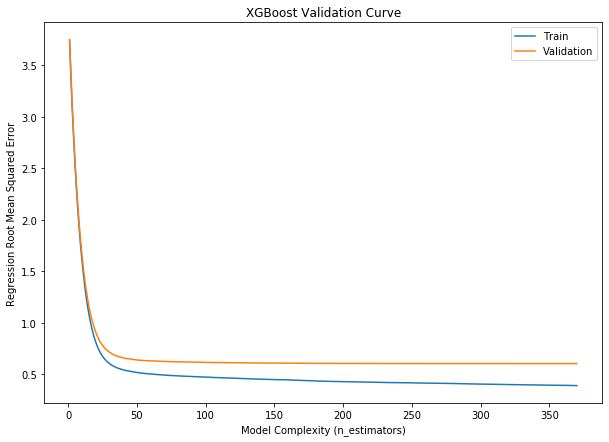

In [0]:
# XGBoost Validation Curve for n_estimators
results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

iterations = range(1, len(train_rmse) + 1)

plt.figure(figsize=(10,7))
plt.plot(iterations, train_rmse, label='Train')
plt.plot(iterations, val_rmse, label='Validation')
plt.title('XGBoost Validation Curve')
plt.ylabel('Regression Root Mean Squared Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

#Partial Dependence Plots

In [0]:
# Assign to X, y
target = 'diameter'
features = train.columns.drop('diameter')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [0]:
X_train.head()

orbit_id         e  ...  last_obs_year  last_obs_month
47132    JPL 16  0.120403  ...           2019               5
3303     JPL 30  0.054356  ...           2019              11
20238    JPL 20  0.127246  ...           2019              11
118643    JPL 5  0.328479  ...           2010               2
9231     JPL 32  0.208735  ...           2019              11

[5 rows x 22 columns]

In [0]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred_train = gb.predict(X_train)
y_pred_val = gb.predict(X_val)
print('Gradient Boosting R^2 for Training Set', r2_score(y_train, y_pred_train))
print('Gradient Boosting R^2 for Validation Set', r2_score(y_val, y_pred_val))
print(f'Training MAE: {mean_absolute_error(y_train,y_pred_train)} km (standarized)')
print(f'Validation MAE: {mean_absolute_error(y_val,y_pred_val)} km (standarized)')
print(f'Training MSE: {mean_squared_error(y_train,y_pred_train)} km (standarized)')
print(f'Validation MSE: {mean_squared_error(y_val,y_pred_val)} km (standarized)')

Gradient Boosting R^2 for Training Set 0.904295776748873
Gradient Boosting R^2 for Validation Set 0.8976704590302819
Training MAE: 0.4376588353177152 km (standarized)
Validation MAE: 0.4494092499837339 km (standarized)
Training MSE: 0.35805440332428706 km (standarized)
Validation MSE: 0.38193951553410826 km (standarized)


In [0]:
example = X_val.iloc[[0]]
example

orbit_id         e  ...  last_obs_year  last_obs_month
89723   JPL 14  0.188575  ...           2019              10

[1 rows x 22 columns]

In [0]:
pred = gb.predict(example)[0]
print(f'Predicted diameter in km: {pred:.2f}')

Predicted diameter in km: 5.42


In [0]:
train['n_obs_used'].describe()

count    80957.000000
mean       617.706869
std        517.200216
min          5.000000
25%        215.000000
50%        469.000000
75%        900.000000
max       4481.000000
Name: n_obs_used, dtype: float64

In [0]:
import numpy as np

def vary_n_obs_used(model, example):
    print('Vary n_obs_used, hold other features constant', '\n')
    example = example.copy()
    preds = []
    for n_obs_used in range(0, 5000, 5):
        example['n_obs_used'] = n_obs_used
        pred = model.predict(example)[0]
        print(f'Predicted diameter in km: {pred:.2f}%')
        print(example.to_string(), '\n')
        preds.append(pred)
    print('Difference between predictions')
    print(np.diff(preds))
        
vary_n_obs_used(gb, example)

In [0]:
example2 = X_val.iloc[[2]]
vary_n_obs_used(gb, example2)

Vary n_obs_used, hold other features constant 

Predicted diameter in km: 1.87%
      orbit_id         e         a         i          om           w          ma         n            tp     moid  moid_jup class    producer  data_arc  n_obs_used      rms  albedo  diameter_sigma  first_year_obs  first_month_obs  last_obs_year  last_obs_month
44682   JPL 17  0.074856  2.786135  2.352661  169.273677  177.179283  307.767435  0.211934  2.458847e+06  1.56938   2.31366   MBA  Otto Matic    9413.0           0  0.58645   0.133           0.382            1994                1           2019              10 

Predicted diameter in km: 1.87%
      orbit_id         e         a         i          om           w          ma         n            tp     moid  moid_jup class    producer  data_arc  n_obs_used      rms  albedo  diameter_sigma  first_year_obs  first_month_obs  last_obs_year  last_obs_month
44682   JPL 17  0.074856  2.786135  2.352661  169.273677  177.179283  307.767435  0.211934  2.458847e+0

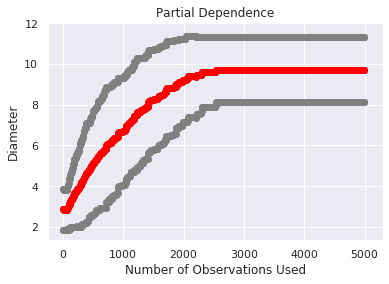

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()

examples = pd.concat([example, example2])
for n_obs_used in range(0, 5000, 5):
    examples['n_obs_used'] = n_obs_used
    preds = gb.predict(examples)
    for pred in preds:
        plt.scatter(n_obs_used, pred, color='grey')
    plt.scatter(n_obs_used, np.mean(preds), color='red')
    plt.title('Partial Dependence')
    plt.xlabel('Number of Observations Used')
    plt.ylabel('Diameter')

In [0]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [0]:
feature='n_obs_used'

isolated = pdp_isolate(
    model = gb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2b474630>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2b728438>})

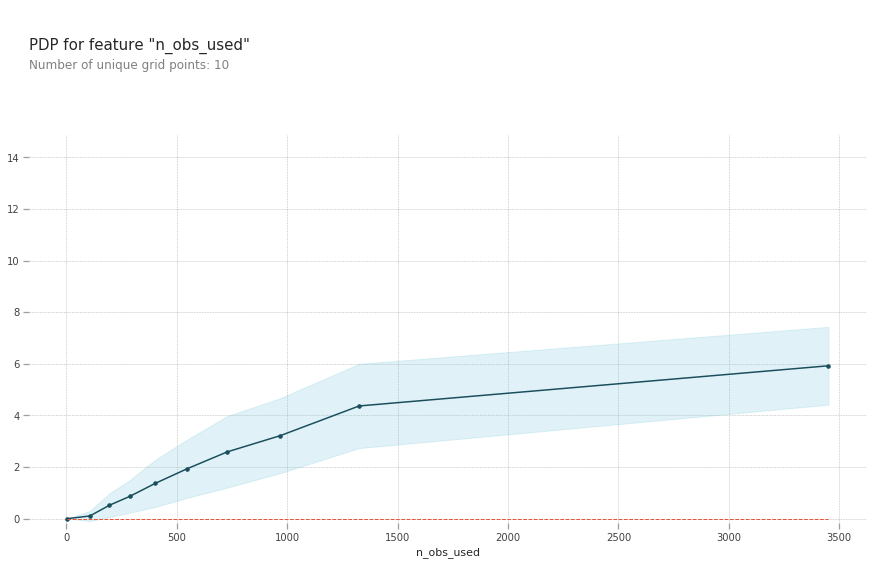

In [0]:
pdp_plot(isolated, feature_name=feature)

(0, 5000)

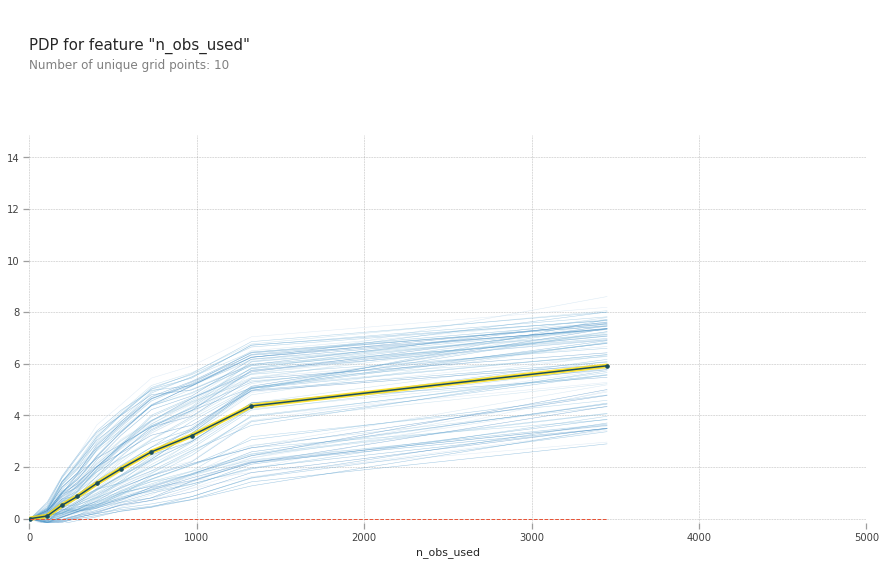

In [0]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0, 5000)

### We can customize it

PDPbox
- [API Reference: PDPIsolate](https://pdpbox.readthedocs.io/en/latest/PDPIsolate.html)

In [0]:
dir(isolated)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_type',
 'count_data',
 'display_columns',
 'feature',
 'feature_grids',
 'feature_type',
 'hist_data',
 'ice_lines',
 'n_classes',
 'pdp',
 'percentile_info',
 'which_class']

In [0]:
grid = isolated.feature_grids
pdp = isolated.pdp

In [0]:
lines = isolated.ice_lines.sample(100).T

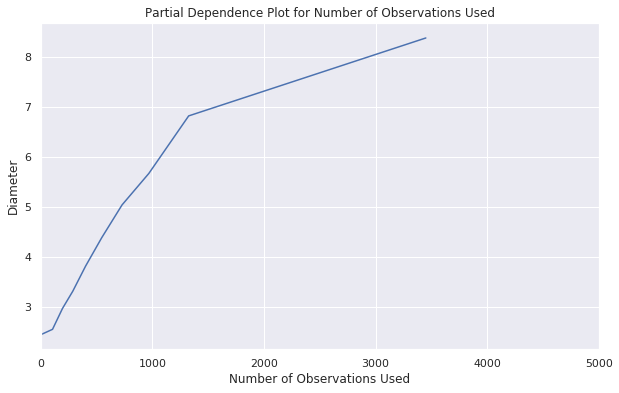

In [0]:
plt.figure(figsize=(10,6))
plt.plot(grid, pdp)
plt.xlim(0,5000)
plt.ylabel('Diameter')
plt.xlabel('Number of Observations Used')
plt.title('Partial Dependence Plot for Number of Observations Used');

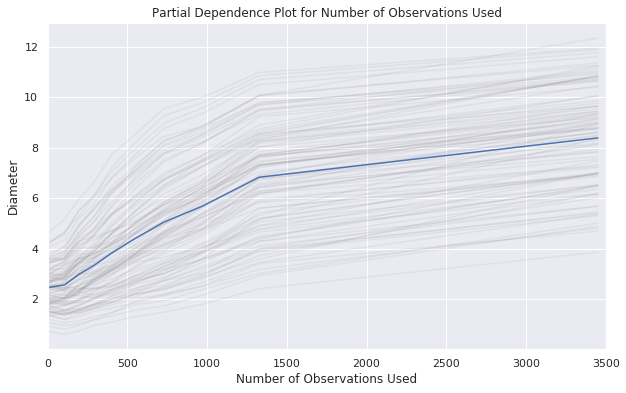

In [0]:
lines.plot(color='grey', alpha=0.1, legend=False, figsize=(10,6))
plt.plot(grid, pdp)
plt.xlim(0,3500)
plt.ylabel('Diameter')
plt.xlabel('Number of Observations Used')
plt.title('Partial Dependence Plot for Number of Observations Used');

In [0]:
feature='albedo'

isolated = pdp_isolate(
    model = gb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2ce46f28>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f31b5e550>})

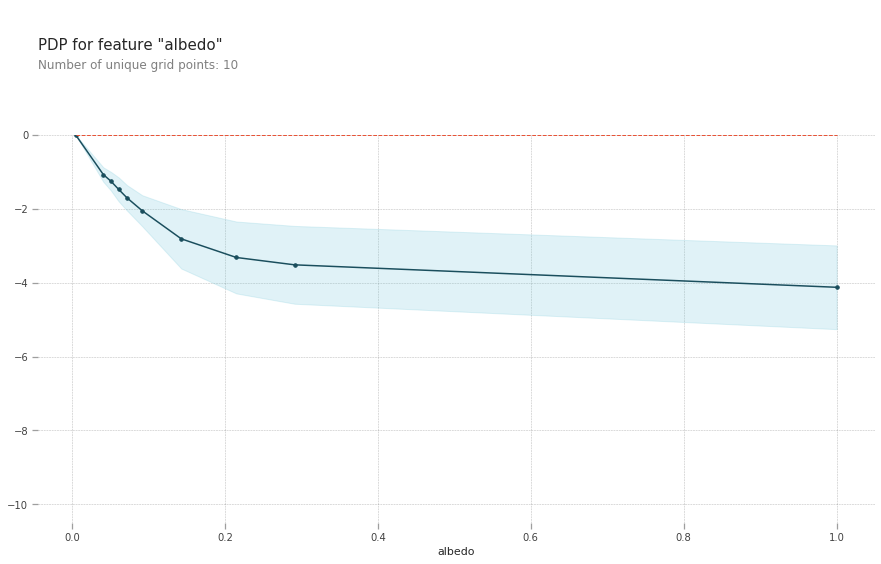

In [0]:
pdp_plot(isolated, feature_name=feature)

In [0]:
feature='i'

isolated = pdp_isolate(
    model = gb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2b81fe80>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2cdfa9e8>})

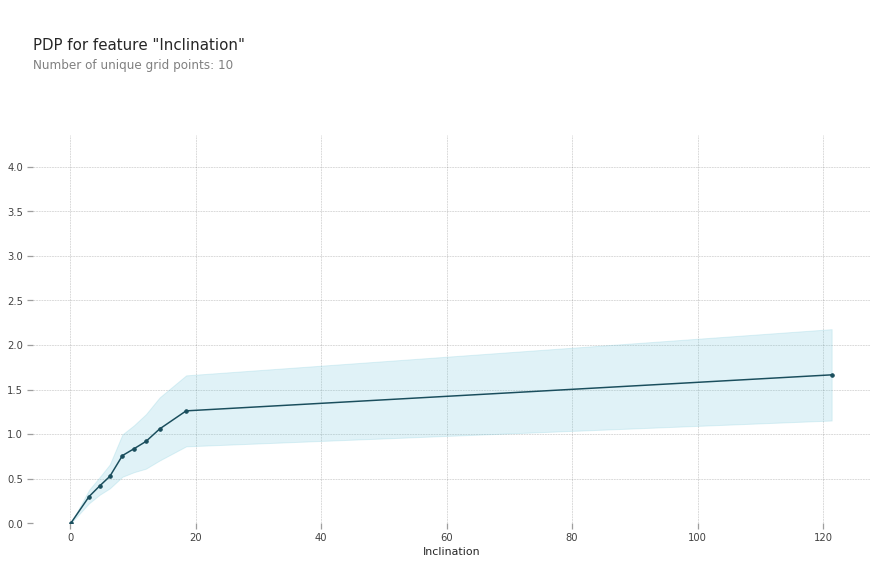

In [0]:
pdp_plot(isolated, feature_name='Inclination')

### Partial Dependence Plot with 2 Features


See interactions!

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20:
- With the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2accde80>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2b2625f8>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


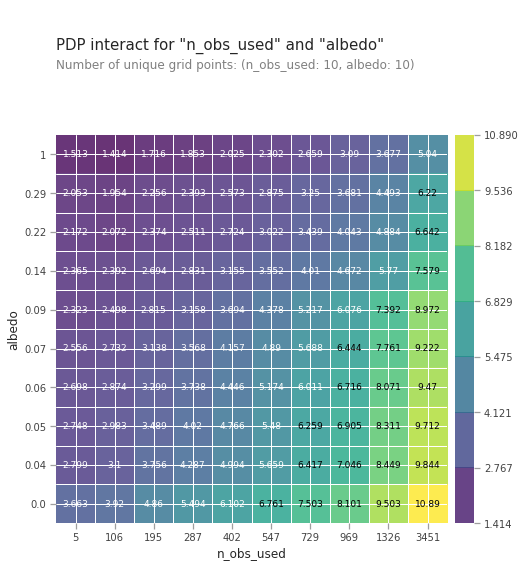

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['n_obs_used','albedo']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

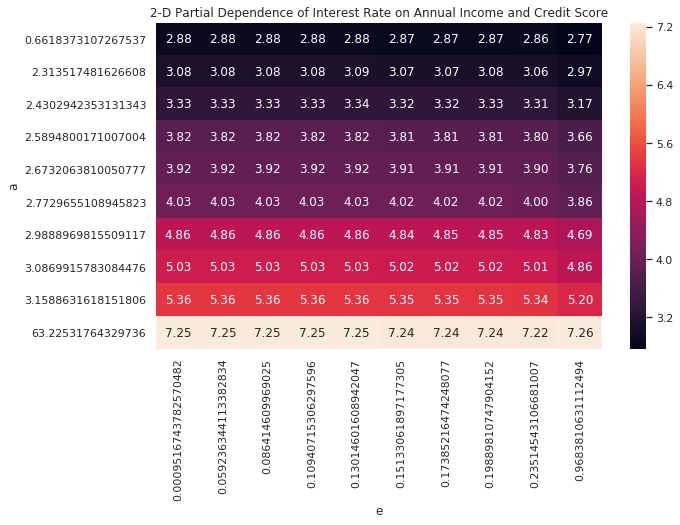

In [0]:
pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)

plt.figure(figsize=(10,6))
sns.heatmap(pdp, annot=True, fmt='.2f')
plt.title('2-D Partial Dependence of Diameter on Number of Observations Used and Albedo');

## 3D plotly

In [0]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns,
    y=pdp.index,
    z=pdp.values
)

fig = go.Figure(surface)
fig.show()

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2ad485c0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2add5198>})

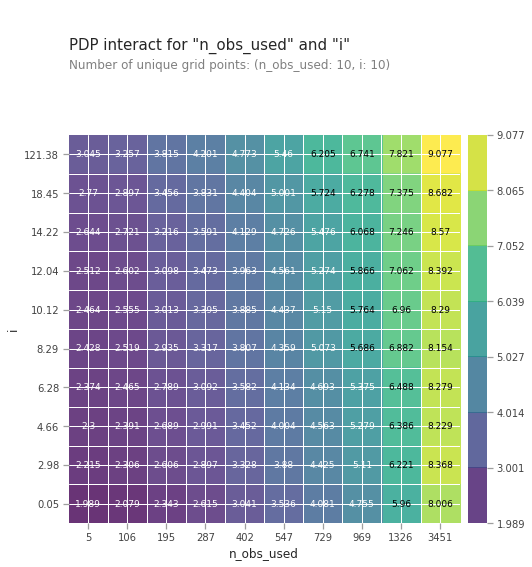

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['n_obs_used','i']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2b420d30>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2f2ae45198>})

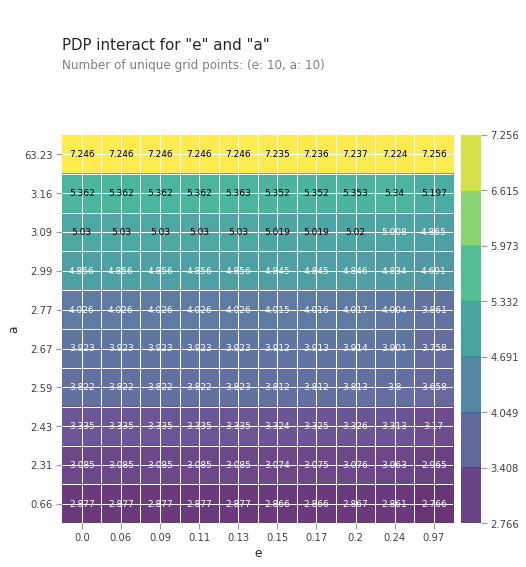

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['e','a']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

# FINAL RESULTS SUMMARIZED



#predict function to be determined

In [0]:
def predict(n_obs_used, albedo, i, a, moid, rms, model):

  # Make df from inputs
  df = pd.DataFrame(
      data=[[n_obs_used, albedo, i, a, moid, rms]],
      columns=['n_obs_used', 'albedo', 'i', 'a', 'moid','rms']      
  )

  # Make a prediction
  pred = model.predict(df)[0]
  
  # Calculate the shap values
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(df)

  # Print some results
  feature_names = df.columns
  feature_values = df.values[0]
  shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

  result = f'${pred:,.0f} estimated diameter for this asteroid. \n\n'
  result += f'Starting from baseline of {explainer.expected_value:,.0f} km in diameter. \n'
  result += shaps.to_string()
  print(result)

  # Show the shapley force plot
  shap.initjs()
  return shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=df
)
  
predict(617, .133, 10.19, 2.75, 1.37, .55, model)

ValueError: ignored

# Best Model [Random Forest Regressor] Test Results

In [0]:
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

features = ['orbit_id', 'e', 'a', 'i', 'om', 'w', 'ma', 'n', 'tp', 'moid','moid_jup', 'class', 'producer', 'data_arc', 'n_obs_used', 'rms','diameter', 'albedo', 'diameter_sigma', 'first_year_obs','first_month_obs', 'last_obs_year', 'last_obs_month']
target = 'diameter'

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_train = train.drop(columns=target)

X_test = test[features]
y_test = test[target]
X_test = test.drop(columns=target)


pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, cols=['class','producer']), 
    ce.OrdinalEncoder(cols = ['orbit_id']),
    StandardScaler(),
    RandomForestRegressor(n_estimators=450, max_depth=None, max_features=.77, min_samples_leaf=3, min_samples_split=3,  n_jobs=-1, random_state=42)
)

pipeline.fit(X_train,y_train)

y_pred_test = pipeline.predict(X_test)

mae_test = mean_absolute_error(y_test,y_pred_test)
mse_test = mean_squared_error(y_test,y_pred_test)
r2_test = pipeline.score(X_test, y_test)
r2_test_percent = 100*r2_test


print(f'Testing R^2 value: {r2_test_percent:.2f}%')
print(f'Testing MAE: {mae_test:.4f} km')
print(f'Testing MSE: {mse_test:.4f} km')



Testing R^2 value: 91.08%
Testing MAE: 0.4092 km
Testing MSE: 0.3321 km


# APP/BLOG

In [0]:
# build model only using 6 features (lower accuracy, lower r2, worse but user enters manualy or slider and get predictions). model in app will be 6 features in app EASYIEST APPROACH
# 6-10 well known asteroid have drop down where user select asteroid (name it by date or name) be chosing from one of the asteorids (look it up in data frame use 35 features and return actual diameter, predicted, and error/shaply plot)
  # selecting returns some data and describe the shaply plot
  # train on data up till 2018 and predict on 10-20 on most interesting in 2019
  # pose the question how well can machine learning models predict asteroid diameter on the previous 20 years of data and on the 2019 asteroids. 
  # 20-25 in drop down menu (make sure from 2019 and )

1. Introduce your dataset and problem statement (target you are predicting, possible leakage, etc.)
2. Discuss the baseline model performance: mean for regression, majority class for classification, and/or a linear model with 2-3 of the most important features only
3. Briefly mention your best model so far (how many features, model type, pipeline, etc.)
4. Your vision for the end goal of your build week (goal for blog post or functionality you hope to build in the app)

  # blog - 3 to 5 images which are the most telling to explain my model. 

  intro - whats dataset, what predicting, head of df

  process (visualizations, transfer target with iqr, code snippets, say baseline, linear, tree/forrest )

  - have table of all the mean baselines and improvemnts in a table 
  - explain all the models
  - at the end show the best model with a shapely plot 
  - dive into features or pdp on best model and shape for a specific open
  - try shap summary plot (GREAT way to find most import feautres ) -> great ending visualization for feature importance

  life lesson road blocks encoutnered etc

In [0]:
1. Introduce your dataset and problem statement (target you are predicting, possible leakage, etc.)
2. Discuss the baseline model performance: mean for regression, majority class for classification, and/or a linear model with 2-3 of the most important features only
3. Briefly mention your best model so far (how many features, model type, pipeline, etc.)
4. Your vision for the end goal of your build week (goal for blog post or functionality you hope to build in the app)